## Set up Google Colab environment

In [0]:
### Set colaboratory True to run in Google Colaboratory. 
colab = True

if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    ## Specify a directory in Google Drive
    dir = '/content/drive/My Drive/Colab Notebooks/Keras_MNIST'
    os.chdir(dir)
    #os.getcwd()
    #os.listdir()

    ## Check the uptime. (Google Colab reboots every 12 hours)
    !cat /proc/uptime | awk '{print "Uptime is " $1 /60 /60 " hours (" $1 " sec)"}'
    ## Check the GPU info
    !nvidia-smi
    ## Check the Python version
    !python --version

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Uptime is 0.102225 hours (368.01 sec)
Tue Jan 29 14:19:10 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+

## Import modules

In [0]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

tf.__version__

'1.12.0'

## Set up resumable logging feature

In [0]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

class LogFileProcessing():
    def __init__(self, resume_if_possible = True, log_file_path = 'training_log.csv', verbose = 1):
        self.log_file_path = log_file_path
        self.verbose = verbose
        self.update()
        if not resume_if_possible:
            self.clean_up()
            self.update()
    def update(self):
        log_file_path = self.log_file_path
        log_file_list = glob.glob(log_file_path)
        log_file_list.sort()
        self.log_file_list = log_file_list
        if self.verbose >= 2:
            print('Log file:', log_file_list)
        log_file_exists = len(log_file_list) >= 1
        self.log_file_exists = log_file_exists
    def truncate(self, epoch_from_model_file):
        log_file_path = self.log_file_path
        self.update()
        ## Remove rows after the epoch of the latest saved model 
        ## (needed because save_best_only option of checkpoint is set to True.)
        epoch_from_log_file = int(self.get_column_value('epoch'))
        epoch_diff = epoch_from_log_file - epoch_from_model_file 
        with open(log_file_path, 'r') as f:
            lines = f.readlines()
        if self.verbose >= 3:
            print('Log file contents read:', lines)
        lines_truncated = lines[:-(epoch_diff + 1)]
        with open(log_file_path, 'w') as f:
            f.writelines(lines_truncated)
        if self.verbose >= 3:
            print('New log file contents', lines_truncated)
    def clean_up(self):
        self.update()
        if self.log_file_exists:
            for f in self.log_file_list:
                os.remove(f)
            self.update()
    def get_df(self, dtype=None):
        self.update()
        if self.log_file_exists:
            try:
                return pd.read_csv(self.log_file_path, dtype=dtype)
            except:
                pass
        if self.verbose >= 2:
            print('Log file was not read as a DataFrame.')
        return None
    def get_column_value(self, column, default = '0'):
        log_df = self.get_df(dtype=str)
        if log_df is not None:
            if log_df.shape[0] >= 1:
                column_value = log_df.iloc[-1][column]
                return column_value
        if self.verbose >= 2:
            print('{} assumed to be {}.'.format(column, default))
        column_value = default
        return column_value    
    def plot_log(self, show_table = True):
        log_all_df = self.get_df()
        if log_all_df is not None:
            model_id_list = log_all_df['_Model_id'].unique()
            print('Model id list: ', model_id_list)
            for model_id in model_id_list: 
                print('### Model id: ', model_id)
                log_df = log_all_df.query('_Model_id == "{}"'.format(model_id))
                if show_table:
                    display(log_df)
                log_df.set_index('epoch')[['acc', 'val_acc']].plot(style='.-', title='Accuracy vs Epoch')
                plt.show()
                log_df.set_index('epoch')[['loss', 'val_loss']].plot(style='.-', title='Loss vs Epoch')
                plt.show()
                log_df.set_index('epoch')[['Comp_time', 'Cum_comp_time']].plot(style='.-', title='Computation Time (sec) vs Epoch')
                plt.show()          
            
class ModelFileProcessing():
    def __init__(self, model_id = '', model_file_prefix = 'model', model_file_suffix = '.hdf5', verbose = 1):
        model_file_prefix = model_file_prefix + model_id + '_epoch'
        self.model_file_prefix = model_file_prefix
        self.model_file_suffix = model_file_suffix
        self.verbose = verbose
        model_file_path = model_file_prefix + '{epoch:06d}' + model_file_suffix
        self.model_file_path = model_file_path
        self.update()
    def update(self):
        model_file_prefix = self.model_file_prefix
        model_file_suffix = self.model_file_suffix
        model_file_list = glob.glob(model_file_prefix + '*' + model_file_suffix)
        model_file_list.sort()
        if self.verbose >= 2:
            print('Model files: ', model_file_list)
        self.model_file_list = model_file_list
        model_file_exists = len(model_file_list) >= 1
        self.model_file_exists = model_file_exists

        latest_model_file = model_file_list[-1] if model_file_exists else None
        self.latest_model_file = latest_model_file

        latest_epoch = int(latest_model_file[len(model_file_prefix):-len(model_file_suffix)]) \
            if model_file_exists else 0
        self.latest_epoch = latest_epoch

        multiple_model_files_exist = len(model_file_list) >= 2
        self.multiple_model_files_exist = multiple_model_files_exist
    def clean_up_old(self):
        self.update()
        ## Delete all model files excpet the latest to save space
        if self.multiple_model_files_exist:
            for f in self.model_file_list[:-1]:
                os.remove(f)  
    def clean_up_all(self):
        self.update()
        ## Delete all model files if they exist.
        if self.model_file_exists:
            for f in self.model_file_list:
                os.remove(f)   
                
class ModelParams(keras.callbacks.Callback):
    def __init__(self, model_param_dict = {}, verbose = 2):
        self.model_param_dict = model_param_dict
        self.verbose = verbose
    def on_epoch_end(self, epoch, logs={}):
        if self.verbose >= 3:
            print('Model params: ', self.model_param_dict)
        ## Add the model parameters to the logs
        logs.update(self.model_param_dict)
        if self.verbose >= 3:
            print('logs: ', logs)
        
class OldModelFileCleanup(keras.callbacks.Callback):
    def __init__(self, mfp):
        self.mfp = mfp
    def on_epoch_end(self, epoch, logs={}):     
        self.mfp.clean_up_old()
        
import time          
class CompTime(keras.callbacks.Callback):
    def __init__(self, lfp):
        self.lfp = lfp
        self.verbose = lfp.verbose
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs={}):
        ## Calculate computation time for the epoch
        comp_time = time.time() - self.epoch_time_start
        logs['Comp_time'] = comp_time
        if self.verbose >= 2:
            print('Computation time: {} sec'.format(comp_time))
        ## Calculate cumulative computation time up to the epoch
        cum_comp_time_past = \
        float(self.lfp.get_column_value('Cum_comp_time')) if epoch >= 1 else 0
        logs['Cum_comp_time'] = cum_comp_time_past + comp_time
          
def setup_model_and_callbacks(lfp, create_model, input_shape, resume_if_possible = True,
                             model_param_dict = {}, verbose = 1, early_stopping_patience = 5):
    
    mfp = ModelFileProcessing(model_id = model_param_dict['_Model_id'], verbose = 1)
    resume_flag = resume_if_possible and mfp.model_file_exists and lfp.log_file_exists ## To Do: if the model Id entry exists in the CSV log file.

    if resume_flag:
        ## Load the saved model
        model = keras.models.load_model(mfp.latest_model_file)
        print('Use {} to resume fitting.'.format(mfp.latest_model_file))
        initial_epoch = mfp.latest_epoch
        ## Truncate the log file
        lfp.truncate(epoch_from_model_file = mfp.latest_epoch) 

    if not resume_flag:
        ## Create a basic model instance
        model = create_model(input_shape)
        print('Model created.')
        initial_epoch = 0
        ## Delete all model files if they exist.
        mfp.clean_up_all()

    ## Create checkpoint callback
    check_point_ = tf.keras.callbacks.ModelCheckpoint(filepath = mfp.model_file_path, 
        monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'auto', 
        save_weights_only = False, period = 1)
    
    ## Create old model file cleanup callback
    old_model_file_cleanup_ = OldModelFileCleanup(mfp)
    
    ## Create computation time callback
    comp_time_ = CompTime(lfp)
    
    ## Create model params callback
    model_params_ = ModelParams(model_param_dict)

    ## Create CSV logger callback
    csv_logger_ = tf.keras.callbacks.CSVLogger(filename = lfp.log_file_path, separator=',',
                                               append = True)

    ## Create early stopping callback
    early_stopping_ = tf.keras.callbacks.EarlyStopping(monitor='val_acc', 
        min_delta=0, patience=early_stopping_patience, verbose=1, mode='auto', baseline=None)

    callbacks = [check_point_, old_model_file_cleanup_, 
                 model_params_, comp_time_, csv_logger_, early_stopping_]

    return model, callbacks, initial_epoch

## Set up dataset

In [0]:
dataset_name = 'MNIST_1000samples' ## logged in the log file.

if dataset_name == 'MNIST_1000samples':
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    print('x_train: ', x_train.shape)
    print('y_train', y_train.shape)
    print('x_test: ', x_test.shape)
    print('y_test', y_test.shape)

    input_shape = x_train.shape[1:]
    print('input_shape: ', input_shape )

    num_classes = 10

    x_train = x_train / 255.0
    x_test = x_test / 255.0

    ## Reduce samples size to speed up 
    n = 1000
    y_train = y_train[:n]
    y_test = y_test[:n]

    x_train = x_train[:n]
    x_test = x_test[:n]
    
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

    print('\n### data after processing')
    print('x_train: ', x_train.shape)
    print('y_train', y_train.shape)
    print('x_test: ', x_test.shape)
    print('y_test', y_test.shape)
 
    input_shape = x_train.shape[1:]
    print('input_shape: ', input_shape )

x_train:  (60000, 28, 28)
y_train (60000,)
x_test:  (10000, 28, 28)
y_test (10000,)
input_shape:  (28, 28)

### data after processing
x_train:  (1000, 28, 28, 1)
y_train (1000,)
x_test:  (1000, 28, 28, 1)
y_test (1000,)
input_shape:  (28, 28, 1)


## Set up model parameters

In [0]:
NotUsed="""
### Grid Search 
 
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD, Adagrad, RMSprop, Adam

batch_size_list = [64]

optimizer_dict = {}
#optimizer_dict['SGD'] = SGD()
#optimizer_dict['SGD_momentum_0.5'] = SGD(momentum = 0.5)
#optimizer_dict['SGD_momentum_0.9'] = SGD(momentum = 0.9)
#optimizer_dict['SGD_momentum_0.99'] = SGD(momentum = 0.99)         
#optimizer_dict['Adagrad'] = Adagrad()
#optimizer_dict['RMSprop'] = RMSprop()
optimizer_dict['Adam'] = Adam()

activation_list = []
activation_list.append('relu')
#activation_list.append('sigmoid')
#activation_list.append('elu')

objective_list = []
objective_list.append('sparse_categorical_crossentropy')
#objective_list.append('categorical_crossentropy')

dropout_rate_list = [0.0, 0.5]

model_param_dict_list = []
i = 0
for batch_size in batch_size_list:
    for optimizer, _ in optimizer_dict.items():
        for activation in activation_list:
            for objective in objective_list:
                for dropout_rate in dropout_rate_list:
                    d = {}
                    d['_Dataset_name'] = dataset_name
                    d['_Model_setup'] = 'Dense_Only'
                    d['_Model_id'] = '{:06d}'.format(i)
                    d['Batch_size'] = batch_size
                    d['Optimizer'] = optimizer
                    d['Acivation'] = activation
                    d['Objective'] = objective
                    d['Dropout_rate'] = dropout_rate
                    i += 1
                    print(d)
                    model_param_dict_list.append(d)
"""

In [0]:
### derivative style 

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D
from keras.optimizers import SGD, Adagrad, RMSprop, Adam, Adadelta, Adamax, Nadam

batch_size_list = [64]

optimizer_dict = {}
optimizer_dict['SGD'] = SGD()
optimizer_dict['SGD_momentum_0.5'] = SGD(momentum = 0.5)
optimizer_dict['SGD_momentum_0.9'] = SGD(momentum = 0.9)
optimizer_dict['SGD_momentum_0.99'] = SGD(momentum = 0.99)         
optimizer_dict['Adagrad'] = Adagrad()
optimizer_dict['RMSprop'] = RMSprop()
optimizer_dict['Adadelta'] = Adadelta()
optimizer_dict['Adamax'] = Adamax()
optimizer_dict['Adadelta'] = Adadelta()

Nadam

optimizer_dict['Adam'] = Adam(lr=0.001)
optimizer_dict['Adam_lr0.0001'] = Adam(lr=0.0001)
optimizer_dict['Adam_lr0.01'] = Adam(lr=0.01)
optimizer_dict['Adam_lr0.1'] = Adam(lr=0.1)

objective_list = []
objective_list.append('sparse_categorical_crossentropy')
#objective_list.append('categorical_crossentropy')

dropout_rate_list = [0.0, 0.5]

base_model_param_dict = {'_Dataset_name': 'MNIST_1000samples', '_Model_setup': 'CNN', '_Model_id': '000000', 'Batch_size': 64, 'Optimizer': 'Adam', 'Acivation': 'relu', 'Objective': 'sparse_categorical_crossentropy', 'Dropout_rate': 0.0}
derivative_dict_list = \
[{'Batch_size': 32},
 {'Batch_size': 128},
 {'Batch_size': 256},
 {'Acivation': 'sigmoid'}, 
 {'Acivation': 'elu'},
 {'Acivation': 'tanh'},
 {'Acivation': 'selu'},
 {'Acivation': 'hard_sigmoid'},
 {'Acivation': 'linear'},
 {'Dropout_rate': 0.3},
 {'Dropout_rate': 0.5},
 {'Dropout_rate': 0.7},
 {'Dropout_rate': 0.9},
 {'Optimizer': 'Adam_lr0.0001'},
 {'Optimizer': 'Adam_lr0.01'},
 {'Optimizer': 'Adam_lr0.1'},
 {'Optimizer': 'SGD'},
 {'Optimizer': 'SGD_momentum_0.5'},
 {'Optimizer': 'SGD_momentum_0.9'},
 {'Optimizer': 'SGD_momentum_0.99'},
 {'Optimizer': 'RMSprop'},
 {'Optimizer': 'Adagrad'},
 {'Optimizer': 'Adadelta'}]

model_param_dict_list = [base_model_param_dict]
print(base_model_param_dict)

for i, derivative_dict in enumerate(derivative_dict_list, 1):
    model_param_dict = base_model_param_dict.copy()
    model_param_dict.update({'_Model_id': '{:06d}'.format(i)})
    model_param_dict.update(derivative_dict)
    model_param_dict_list.append(model_param_dict)
    print(model_param_dict)

Using TensorFlow backend.


{'_Dataset_name': 'MNIST_1000samples', '_Model_setup': 'CNN', '_Model_id': '000000', 'Batch_size': 64, 'Optimizer': 'Adam', 'Acivation': 'relu', 'Objective': 'sparse_categorical_crossentropy', 'Dropout_rate': 0.0}
{'_Dataset_name': 'MNIST_1000samples', '_Model_setup': 'CNN', '_Model_id': '000001', 'Batch_size': 32, 'Optimizer': 'Adam', 'Acivation': 'relu', 'Objective': 'sparse_categorical_crossentropy', 'Dropout_rate': 0.0}
{'_Dataset_name': 'MNIST_1000samples', '_Model_setup': 'CNN', '_Model_id': '000002', 'Batch_size': 128, 'Optimizer': 'Adam', 'Acivation': 'relu', 'Objective': 'sparse_categorical_crossentropy', 'Dropout_rate': 0.0}
{'_Dataset_name': 'MNIST_1000samples', '_Model_setup': 'CNN', '_Model_id': '000003', 'Batch_size': 256, 'Optimizer': 'Adam', 'Acivation': 'relu', 'Objective': 'sparse_categorical_crossentropy', 'Dropout_rate': 0.0}
{'_Dataset_name': 'MNIST_1000samples', '_Model_setup': 'CNN', '_Model_id': '000004', 'Batch_size': 64, 'Optimizer': 'Adam', 'Acivation': 'sigm

## Train models

In [0]:
## Set resume_if_possible = True to resume using a model file if available.
## Set resume_if_possible = False to force fitting from scratch.
#resume_if_possible = True
resume_if_possible = False

epochs = 10
early_stopping_patience = 10

lfp = LogFileProcessing(resume_if_possible = resume_if_possible, verbose = 1)

initial_model_id_num = int(lfp.get_column_value('_Model_id'))

for model_param_dict in model_param_dict_list[initial_model_id_num:]:
    print(model_param_dict)
    ## Assign variables as in the model_param_dict dictionary
    globals().update(model_param_dict) 
    
    if _Model_setup == 'Dense_Only':
        def create_model(input_shape):
            model = Sequential()
            model.add(Flatten(input_shape = input_shape))
            model.add(Dense(512, activation = Acivation))
            model.add(Dropout(Dropout_rate))
            model.add(Dense(10, activation='softmax'))
            model.compile(optimizer = optimizer_dict[Optimizer], 
                          loss=Objective, metrics=['accuracy'])
            return model
    if _Model_setup == 'CNN': 
        def create_model(input_shape):
            model = Sequential()
            model.add(Conv2D(512, kernel_size = (3, 3), strides = (1, 1),
                           activation = Acivation, input_shape = input_shape))
            model.add(Flatten())
            model.add(Dropout(Dropout_rate))
            model.add(Dense(10, activation='softmax'))
            model.compile(optimizer = optimizer_dict[Optimizer], 
                        loss=Objective, metrics=['accuracy'])
            return model
  
    model, callbacks, initial_epoch = \
    setup_model_and_callbacks(lfp, create_model, input_shape, 
                              resume_if_possible = resume_if_possible,
                              model_param_dict = model_param_dict, verbose = 1, 
                              early_stopping_patience = early_stopping_patience)

    model.summary()

    ## Fit 
    model.fit(x_train, y_train, validation_data = (x_test, y_test), shuffle = True,
              batch_size = Batch_size, epochs = epochs, callbacks = callbacks, 
              initial_epoch = initial_epoch)

{'_Dataset_name': 'MNIST_1000samples', '_Model_setup': 'CNN', '_Model_id': '000000', 'Batch_size': 64, 'Optimizer': 'Adam', 'Acivation': 'relu', 'Objective': 'sparse_categorical_crossentropy', 'Dropout_rate': 0.0}
Model created.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 512)       5120      
_________________________________________________________________
flatten_1 (Flatten)          (None, 346112)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 346112)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3461130   
Total params: 3,466,250
Trainable params: 3,466,250
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples, validate on 

Model id list:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
### Model id:  0


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
0,0,relu,64,2.684391,2.684391,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,0,CNN,0.719,0.964969,0.828,0.550224
1,1,relu,64,0.812771,3.497163,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,0,CNN,0.919,0.290259,0.839,0.489218
2,2,relu,64,0.808758,4.305921,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,0,CNN,0.959,0.157361,0.861,0.411189
3,3,relu,64,0.807373,5.113294,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,0,CNN,0.988,0.062579,0.875,0.412613
4,4,relu,64,0.797522,5.910816,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,0,CNN,0.998,0.022156,0.877,0.439573
5,5,relu,64,0.801694,6.712510,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,0,CNN,1.000,0.007825,0.883,0.465641
6,6,relu,64,0.631358,7.343868,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,0,CNN,1.000,0.004597,0.882,0.466570
7,7,relu,64,0.633695,7.977563,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,0,CNN,1.000,0.003095,0.881,0.485979
8,8,relu,64,0.797216,8.774779,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,0,CNN,1.000,0.002103,0.886,0.488512
9,9,relu,64,0.634543,9.409323,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,0,CNN,1.000,0.001699,0.884,0.498530


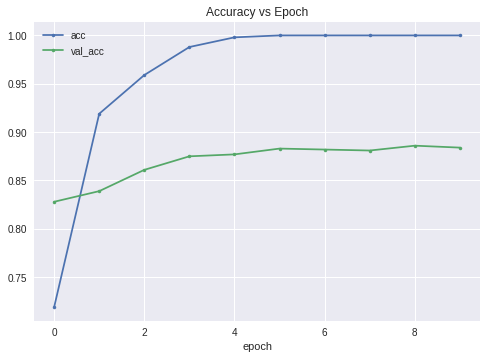

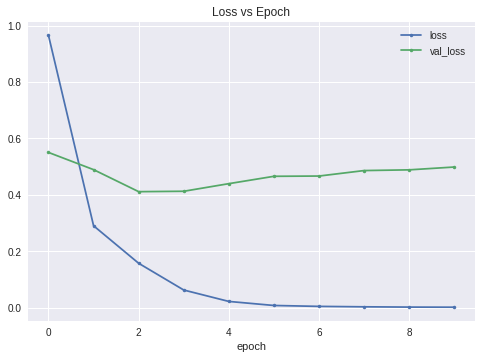

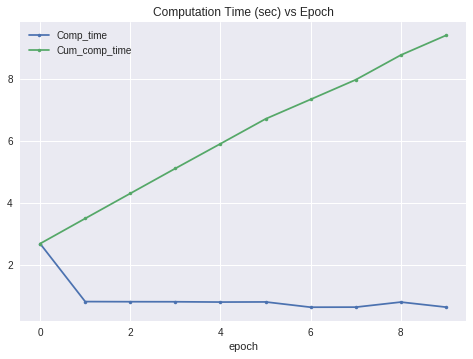

### Model id:  1


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
10,0,relu,32,1.486302,1.486302,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,1,CNN,0.755,0.813249,0.883,0.371934
11,1,relu,32,0.925667,2.411969,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,1,CNN,0.963,0.135721,0.876,0.360279
12,2,relu,32,1.071325,3.483294,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,1,CNN,0.995,0.032034,0.890,0.351180
13,3,relu,32,1.056147,4.539441,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,1,CNN,1.000,0.004934,0.894,0.380912
14,4,relu,32,1.093304,5.632745,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,1,CNN,1.000,0.002037,0.897,0.391143
15,5,relu,32,1.066872,6.699617,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,1,CNN,1.000,0.001303,0.899,0.403259
16,6,relu,32,0.927009,7.626626,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,1,CNN,1.000,0.001018,0.899,0.413132
17,7,relu,32,0.916112,8.542738,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,1,CNN,1.000,0.000828,0.899,0.421767
18,8,relu,32,0.909580,9.452319,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,1,CNN,1.000,0.000693,0.899,0.427458
19,9,relu,32,0.908237,10.360555,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,1,CNN,1.000,0.000594,0.899,0.433530


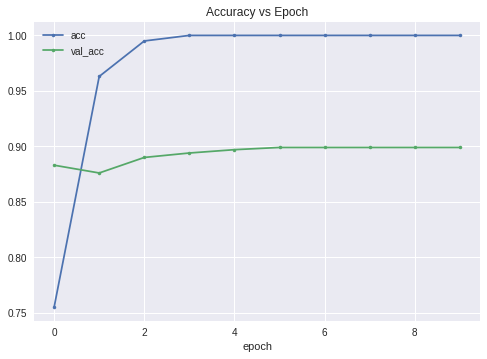

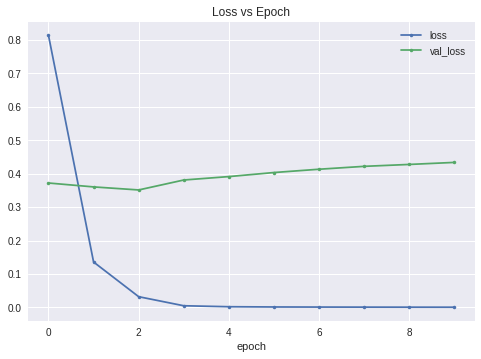

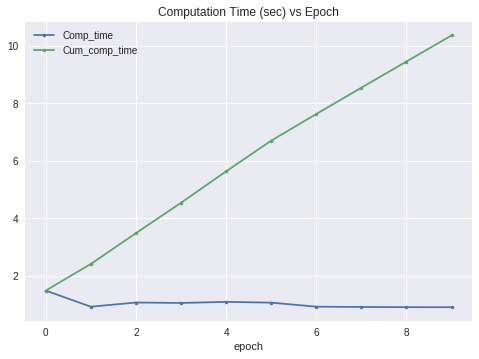

### Model id:  2


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
20,0,relu,128,1.202642,1.202642,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,2,CNN,0.578,1.201507,0.738,0.763343
21,1,relu,128,0.672857,1.875499,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,2,CNN,0.906,0.325189,0.860,0.401084
22,2,relu,128,0.661707,2.537206,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,2,CNN,0.968,0.112888,0.874,0.381427
23,3,relu,128,0.654048,3.191254,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,2,CNN,0.993,0.035111,0.885,0.357221
24,4,relu,128,0.512871,3.704125,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,2,CNN,1.000,0.009537,0.882,0.393020
25,5,relu,128,0.665278,4.369403,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,2,CNN,1.000,0.003050,0.887,0.424547
26,6,relu,128,0.682677,5.052080,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,2,CNN,1.000,0.001389,0.893,0.451450
27,7,relu,128,0.502288,5.554368,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,2,CNN,1.000,0.000928,0.893,0.464947
28,8,relu,128,0.663770,6.218138,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,2,CNN,1.000,0.000695,0.894,0.465152
29,9,relu,128,0.511726,6.729864,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,2,CNN,1.000,0.000532,0.892,0.463234


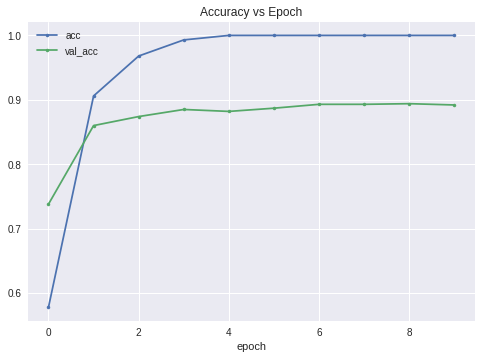

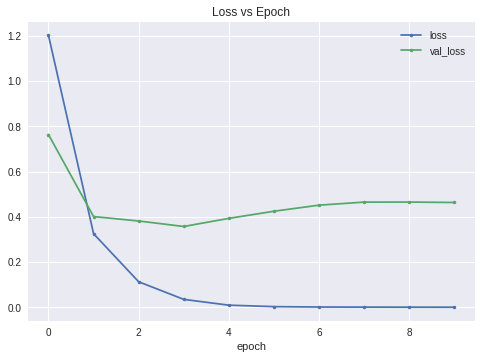

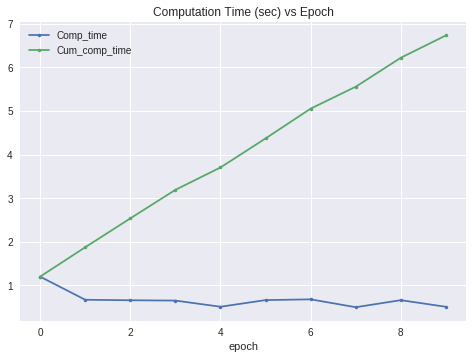

### Model id:  3


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
30,0,relu,256,1.387364,1.387364,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,3,CNN,0.412,1.695043,0.671,1.056855
31,1,relu,256,0.644096,2.031461,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,3,CNN,0.844,0.511626,0.781,0.697447
32,2,relu,256,0.630291,2.661752,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,3,CNN,0.911,0.309804,0.853,0.456831
33,3,relu,256,0.606687,3.268439,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,3,CNN,0.958,0.147391,0.874,0.406487
34,4,relu,256,0.607502,3.875941,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,3,CNN,0.988,0.075082,0.890,0.334293
35,5,relu,256,0.456493,4.332434,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,3,CNN,0.992,0.038211,0.881,0.354323
36,6,relu,256,0.449875,4.782309,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,3,CNN,0.999,0.014424,0.881,0.383940
37,7,relu,256,0.450646,5.232955,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,3,CNN,1.000,0.005910,0.883,0.419081
38,8,relu,256,0.453313,5.686267,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,3,CNN,1.000,0.002937,0.887,0.430036
39,9,relu,256,0.449102,6.135369,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,3,CNN,1.000,0.001520,0.889,0.445546


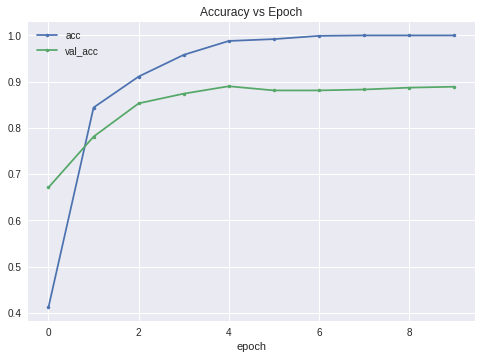

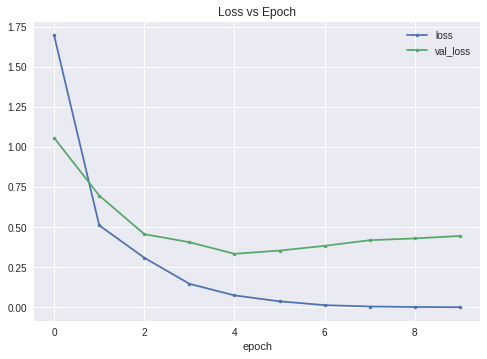

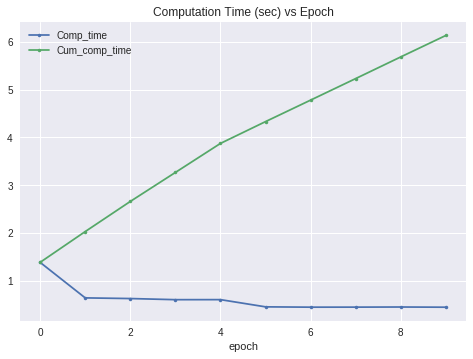

### Model id:  4


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
40,0,sigmoid,64,1.355316,1.355316,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,4,CNN,0.094,13.528885,0.087,14.715823
41,1,sigmoid,64,0.640209,1.995525,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,4,CNN,0.092,14.635232,0.087,14.715823
42,2,sigmoid,64,0.639294,2.634819,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,4,CNN,0.092,14.635232,0.087,14.715823
43,3,sigmoid,64,0.636014,3.270833,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,4,CNN,0.092,14.635232,0.087,14.715823
44,4,sigmoid,64,0.642459,3.913291,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,4,CNN,0.092,14.635232,0.087,14.715823
45,5,sigmoid,64,0.633675,4.546966,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,4,CNN,0.092,14.635232,0.087,14.715823
46,6,sigmoid,64,0.632044,5.179010,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,4,CNN,0.092,14.635232,0.087,14.715823
47,7,sigmoid,64,0.635294,5.814304,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,4,CNN,0.092,14.635232,0.087,14.715823
48,8,sigmoid,64,0.638919,6.453223,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,4,CNN,0.092,14.635232,0.087,14.715823
49,9,sigmoid,64,0.635341,7.088565,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,4,CNN,0.092,14.635232,0.087,14.715823


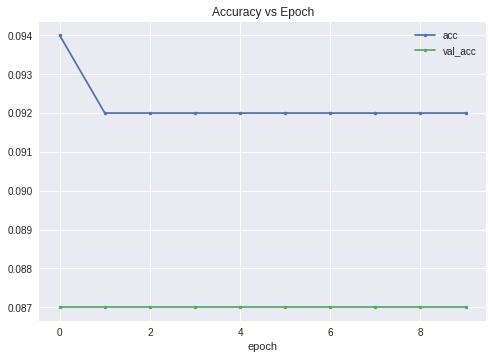

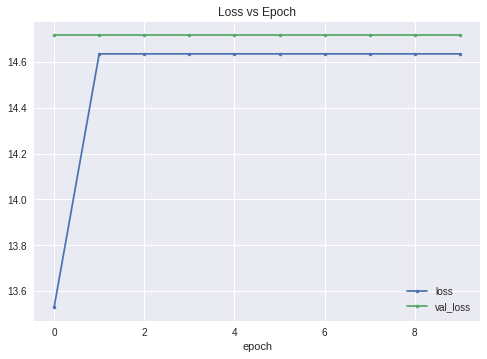

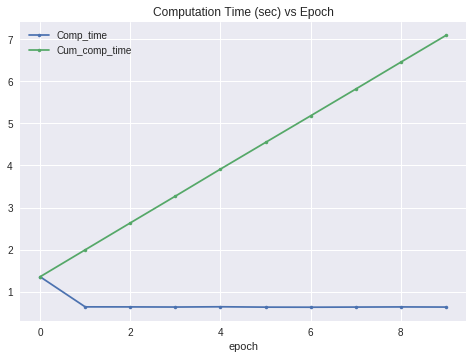

### Model id:  5


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
50,0,elu,64,1.288634,1.288634,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,5,CNN,0.627,1.862945,0.700,2.460512
51,1,elu,64,0.813429,2.102063,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,5,CNN,0.835,0.981945,0.781,1.849838
52,2,elu,64,0.828720,2.930783,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,5,CNN,0.924,0.510728,0.791,1.393166
53,3,elu,64,0.821042,3.751826,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,5,CNN,0.949,0.257941,0.793,1.308494
54,4,elu,64,0.825181,4.577007,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,5,CNN,0.975,0.150113,0.812,1.118737
55,5,elu,64,0.814229,5.391237,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,5,CNN,0.991,0.101421,0.814,1.085455
56,6,elu,64,0.655044,6.046280,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,5,CNN,0.993,0.073437,0.810,1.071985
57,7,elu,64,0.805855,6.852135,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,5,CNN,0.997,0.054707,0.817,1.059138
58,8,elu,64,0.810990,7.663126,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,5,CNN,0.997,0.052296,0.822,1.070556
59,9,elu,64,0.661951,8.325076,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,5,CNN,0.997,0.050730,0.821,1.085972


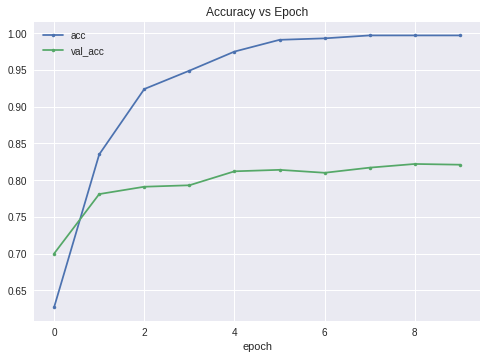

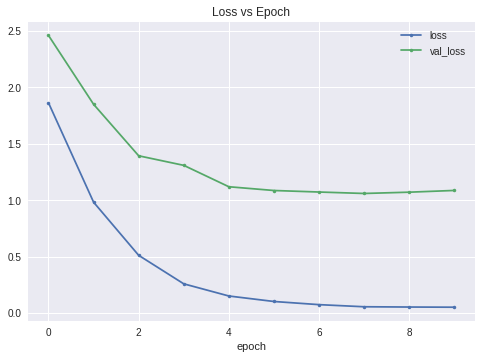

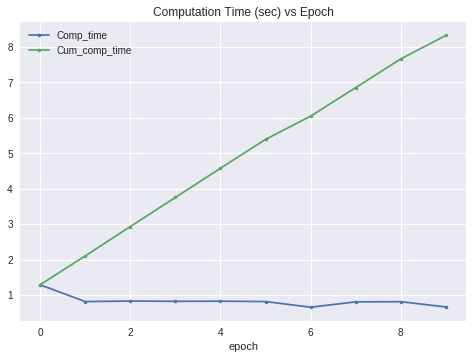

### Model id:  6


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
60,0,tanh,64,1.317200,1.317200,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,6,CNN,0.616,1.937568,0.774,1.414274
61,1,tanh,64,0.644846,1.962046,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,6,CNN,0.878,0.652393,0.761,1.123179
62,2,tanh,64,0.843821,2.805867,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,6,CNN,0.929,0.284566,0.819,0.944526
63,3,tanh,64,0.831707,3.637575,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,6,CNN,0.966,0.194341,0.820,0.960629
64,4,tanh,64,0.644459,4.282033,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,6,CNN,0.982,0.119750,0.816,1.120953
65,5,tanh,64,0.650447,4.932480,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,6,CNN,0.979,0.120894,0.819,1.030178
66,6,tanh,64,0.840192,5.772672,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,6,CNN,0.990,0.095050,0.830,1.024554
67,7,tanh,64,0.644159,6.416831,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,6,CNN,0.995,0.086820,0.823,1.017836
68,8,tanh,64,0.642174,7.059005,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,6,CNN,0.995,0.083658,0.830,0.970719
69,9,tanh,64,0.812421,7.871425,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,6,CNN,0.995,0.082491,0.834,0.965373


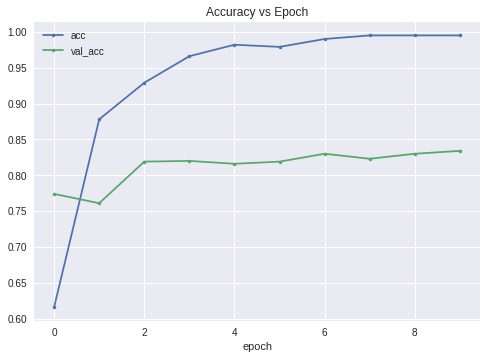

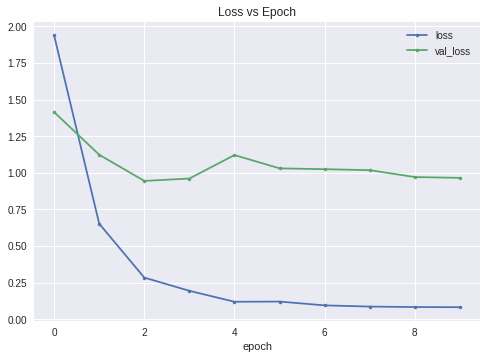

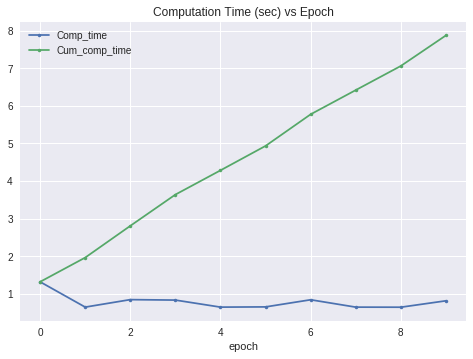

### Model id:  7


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
70,0,selu,64,1.771907,1.771907,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,7,CNN,0.448,6.076014,0.543,6.331279
71,1,selu,64,1.216960,2.988867,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,7,CNN,0.725,3.928327,0.693,4.430733
72,2,selu,64,1.195243,4.184109,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,7,CNN,0.773,3.284036,0.727,3.987169
73,3,selu,64,1.177423,5.361533,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,7,CNN,0.800,2.916269,0.736,3.893855
74,4,selu,64,1.013853,6.375386,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,7,CNN,0.818,2.683383,0.728,3.925051
75,5,selu,64,1.179834,7.555220,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,7,CNN,0.828,2.574045,0.762,3.308109
76,6,selu,64,1.176287,8.731508,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,7,CNN,0.829,2.540856,0.770,3.317441
77,7,selu,64,1.021619,9.753126,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,7,CNN,0.849,2.291293,0.767,3.415416
78,8,selu,64,1.012861,10.765987,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,7,CNN,0.853,2.209899,0.754,3.540837
79,9,selu,64,1.013701,11.779688,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,7,CNN,0.850,2.229809,0.743,3.676239


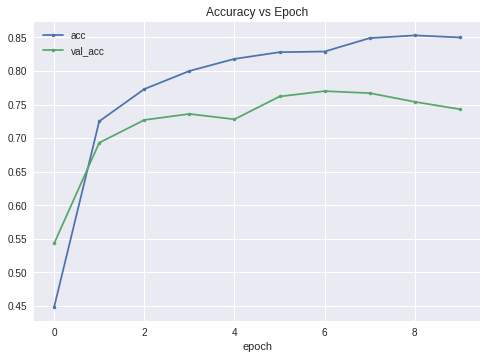

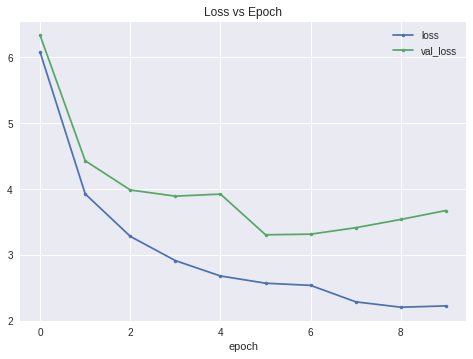

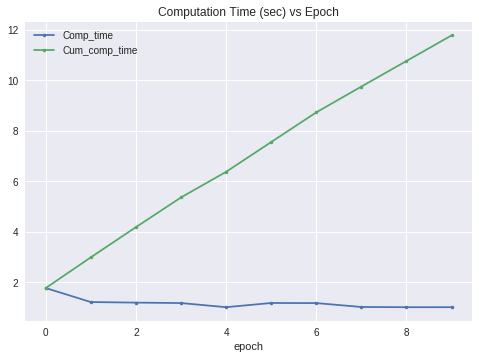

### Model id:  8


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
80,0,hard_sigmoid,64,1.739755,1.739755,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,8,CNN,0.095,13.425779,0.085,14.748059
81,1,hard_sigmoid,64,0.960046,2.699800,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,8,CNN,0.097,14.554642,0.085,14.748059
82,2,hard_sigmoid,64,0.961054,3.660854,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,8,CNN,0.097,14.554642,0.085,14.748059
83,3,hard_sigmoid,64,0.974604,4.635458,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,8,CNN,0.097,14.554642,0.085,14.748059
84,4,hard_sigmoid,64,0.963797,5.599255,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,8,CNN,0.097,14.554642,0.085,14.748059
85,5,hard_sigmoid,64,0.965806,6.565061,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,8,CNN,0.097,14.554642,0.085,14.748059
86,6,hard_sigmoid,64,0.968058,7.533119,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,8,CNN,0.097,14.554642,0.085,14.748059
87,7,hard_sigmoid,64,0.964908,8.498027,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,8,CNN,0.097,14.554642,0.085,14.748059
88,8,hard_sigmoid,64,0.957918,9.455945,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,8,CNN,0.097,14.554642,0.085,14.748059
89,9,hard_sigmoid,64,0.964928,10.420873,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,8,CNN,0.097,14.554642,0.085,14.748059


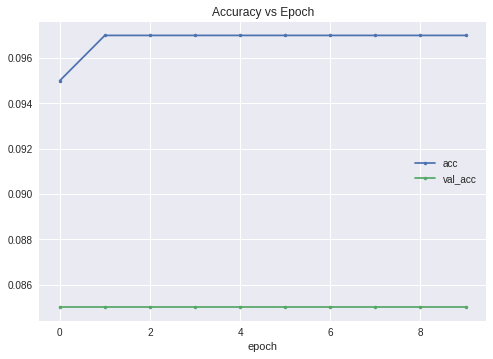

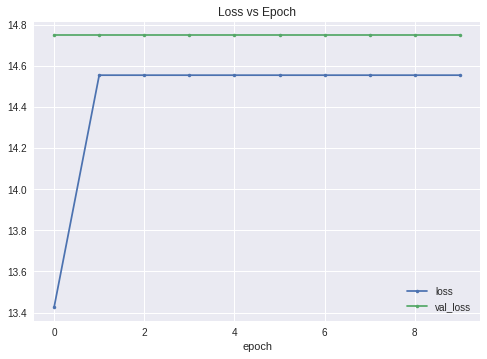

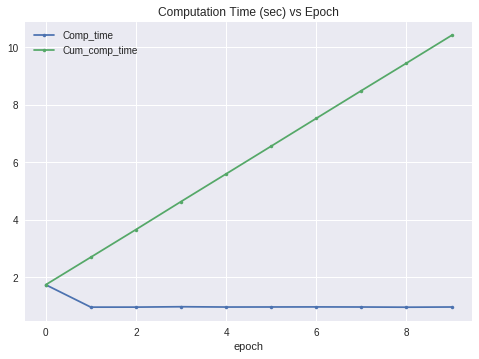

### Model id:  9


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
90,0,linear,64,1.353888,1.353888,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,9,CNN,0.601,2.304949,0.695,2.900020
91,1,linear,64,0.777594,2.131482,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,9,CNN,0.845,1.149376,0.769,1.441407
92,2,linear,64,0.582024,2.713506,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,9,CNN,0.907,0.474500,0.742,1.588010
93,3,linear,64,0.733140,3.446645,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,9,CNN,0.948,0.257612,0.796,1.212721
94,4,linear,64,0.730766,4.177412,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,9,CNN,0.982,0.147803,0.812,1.149751
95,5,linear,64,0.733989,4.911400,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,9,CNN,0.992,0.122275,0.819,1.121682
96,6,linear,64,0.723240,5.634640,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,9,CNN,0.993,0.116504,0.830,1.115454
97,7,linear,64,0.579993,6.214633,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,9,CNN,0.993,0.115030,0.825,1.104183
98,8,linear,64,0.580310,6.794944,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,9,CNN,0.993,0.114243,0.824,1.115313
99,9,linear,64,0.586249,7.381193,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,9,CNN,0.993,0.114071,0.825,1.121664


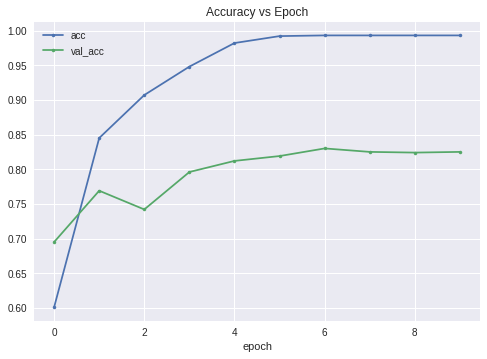

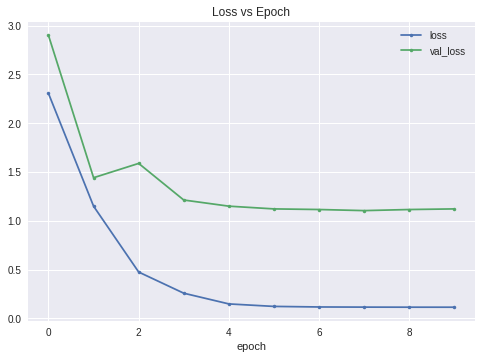

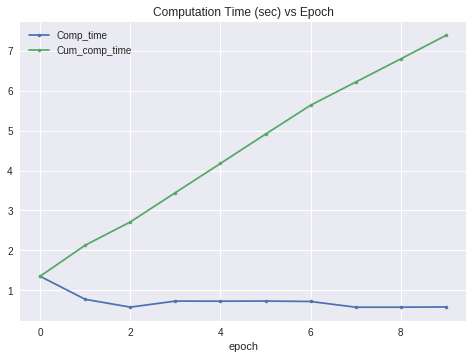

### Model id:  10


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
100,0,relu,64,1.692198,1.692198,0.3,sparse_categorical_crossentropy,Adam,MNIST_1000samples,10,CNN,0.703,1.029730,0.824,0.560908
101,1,relu,64,0.981133,2.673330,0.3,sparse_categorical_crossentropy,Adam,MNIST_1000samples,10,CNN,0.944,0.195080,0.860,0.419742
102,2,relu,64,0.980591,3.653921,0.3,sparse_categorical_crossentropy,Adam,MNIST_1000samples,10,CNN,0.988,0.061462,0.903,0.342164
103,3,relu,64,0.831303,4.485224,0.3,sparse_categorical_crossentropy,Adam,MNIST_1000samples,10,CNN,1.000,0.009259,0.896,0.356516
104,4,relu,64,0.838987,5.324211,0.3,sparse_categorical_crossentropy,Adam,MNIST_1000samples,10,CNN,1.000,0.002317,0.899,0.379290
105,5,relu,64,0.830916,6.155127,0.3,sparse_categorical_crossentropy,Adam,MNIST_1000samples,10,CNN,1.000,0.001187,0.895,0.387504
106,6,relu,64,0.829175,6.984302,0.3,sparse_categorical_crossentropy,Adam,MNIST_1000samples,10,CNN,1.000,0.000772,0.898,0.397787
107,7,relu,64,0.826427,7.810729,0.3,sparse_categorical_crossentropy,Adam,MNIST_1000samples,10,CNN,1.000,0.000618,0.898,0.406009
108,8,relu,64,0.828237,8.638965,0.3,sparse_categorical_crossentropy,Adam,MNIST_1000samples,10,CNN,1.000,0.000516,0.898,0.407424
109,9,relu,64,0.822055,9.461020,0.3,sparse_categorical_crossentropy,Adam,MNIST_1000samples,10,CNN,1.000,0.000435,0.897,0.412739


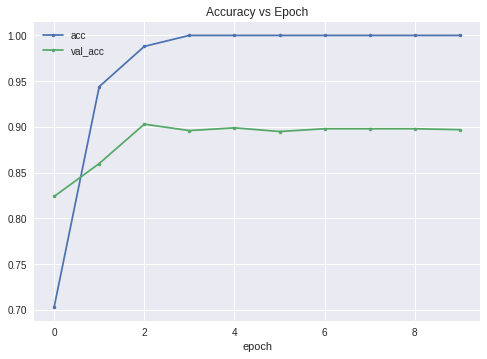

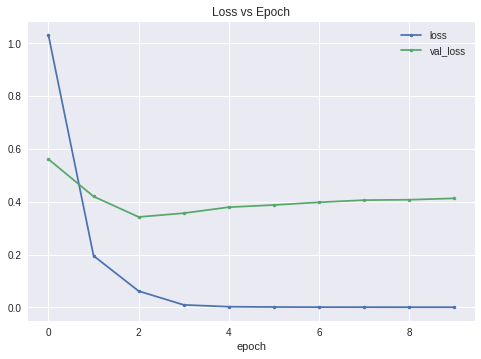

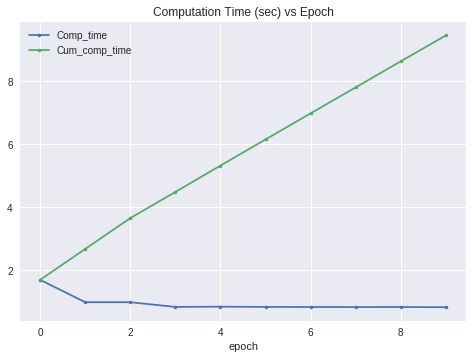

### Model id:  11


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
110,0,relu,64,1.817314,1.817314,0.5,sparse_categorical_crossentropy,Adam,MNIST_1000samples,11,CNN,0.719,0.879758,0.816,0.520978
111,1,relu,64,1.018152,2.835467,0.5,sparse_categorical_crossentropy,Adam,MNIST_1000samples,11,CNN,0.937,0.208488,0.885,0.360274
112,2,relu,64,0.839042,3.674509,0.5,sparse_categorical_crossentropy,Adam,MNIST_1000samples,11,CNN,0.992,0.050611,0.880,0.392747
113,3,relu,64,0.989126,4.663635,0.5,sparse_categorical_crossentropy,Adam,MNIST_1000samples,11,CNN,0.996,0.011292,0.890,0.390034
114,4,relu,64,0.987141,5.650777,0.5,sparse_categorical_crossentropy,Adam,MNIST_1000samples,11,CNN,1.000,0.003093,0.899,0.396833
115,5,relu,64,0.980544,6.631321,0.5,sparse_categorical_crossentropy,Adam,MNIST_1000samples,11,CNN,1.000,0.001381,0.900,0.418154
116,6,relu,64,1.020542,7.651863,0.5,sparse_categorical_crossentropy,Adam,MNIST_1000samples,11,CNN,1.000,0.000928,0.902,0.425392
117,7,relu,64,0.839736,8.491598,0.5,sparse_categorical_crossentropy,Adam,MNIST_1000samples,11,CNN,1.000,0.000671,0.901,0.431513
118,8,relu,64,0.820961,9.312559,0.5,sparse_categorical_crossentropy,Adam,MNIST_1000samples,11,CNN,1.000,0.000546,0.900,0.437717
119,9,relu,64,0.830731,10.143289,0.5,sparse_categorical_crossentropy,Adam,MNIST_1000samples,11,CNN,1.000,0.000437,0.901,0.441748


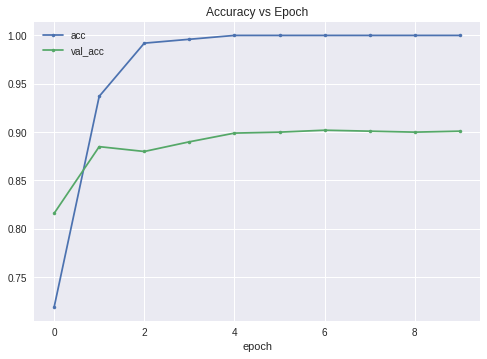

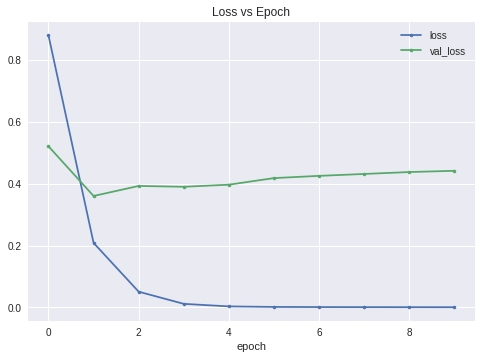

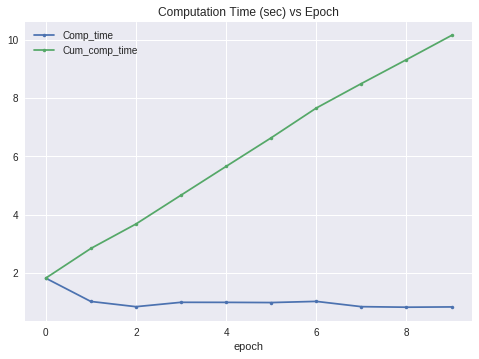

### Model id:  12


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
120,0,relu,64,1.773024,1.773024,0.7,sparse_categorical_crossentropy,Adam,MNIST_1000samples,12,CNN,0.712,0.903905,0.857,0.487365
121,1,relu,64,0.992682,2.765706,0.7,sparse_categorical_crossentropy,Adam,MNIST_1000samples,12,CNN,0.934,0.225264,0.883,0.373486
122,2,relu,64,0.985555,3.751261,0.7,sparse_categorical_crossentropy,Adam,MNIST_1000samples,12,CNN,0.980,0.069065,0.900,0.332025
123,3,relu,64,0.838791,4.590052,0.7,sparse_categorical_crossentropy,Adam,MNIST_1000samples,12,CNN,0.996,0.024611,0.893,0.385184
124,4,relu,64,0.842764,5.432816,0.7,sparse_categorical_crossentropy,Adam,MNIST_1000samples,12,CNN,1.000,0.006860,0.898,0.378701
125,5,relu,64,0.986013,6.418829,0.7,sparse_categorical_crossentropy,Adam,MNIST_1000samples,12,CNN,1.000,0.002745,0.905,0.400333
126,6,relu,64,0.823508,7.242336,0.7,sparse_categorical_crossentropy,Adam,MNIST_1000samples,12,CNN,1.000,0.001503,0.904,0.422198
127,7,relu,64,0.833981,8.076318,0.7,sparse_categorical_crossentropy,Adam,MNIST_1000samples,12,CNN,1.000,0.001202,0.903,0.420991
128,8,relu,64,0.826035,8.902353,0.7,sparse_categorical_crossentropy,Adam,MNIST_1000samples,12,CNN,1.000,0.000979,0.902,0.426699
129,9,relu,64,0.828695,9.731047,0.7,sparse_categorical_crossentropy,Adam,MNIST_1000samples,12,CNN,1.000,0.000903,0.902,0.435880


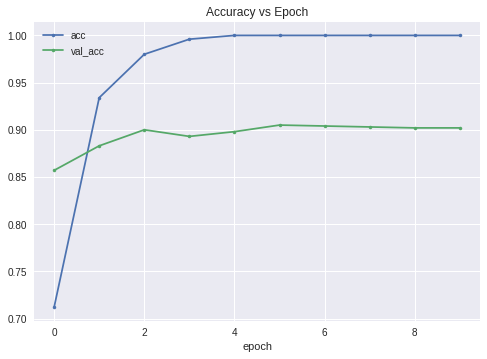

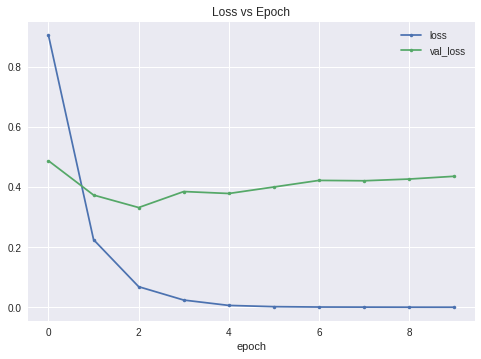

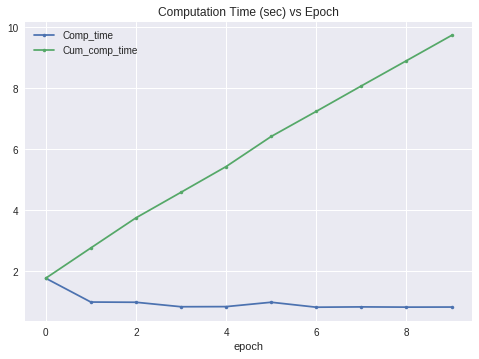

### Model id:  13


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
130,0,relu,64,1.825830,1.825830,0.9,sparse_categorical_crossentropy,Adam,MNIST_1000samples,13,CNN,0.640,1.141755,0.812,0.659324
131,1,relu,64,1.028601,2.854431,0.9,sparse_categorical_crossentropy,Adam,MNIST_1000samples,13,CNN,0.891,0.391935,0.857,0.455999
132,2,relu,64,0.979846,3.834276,0.9,sparse_categorical_crossentropy,Adam,MNIST_1000samples,13,CNN,0.928,0.250132,0.884,0.386349
133,3,relu,64,1.010332,4.844608,0.9,sparse_categorical_crossentropy,Adam,MNIST_1000samples,13,CNN,0.946,0.193833,0.885,0.368026
134,4,relu,64,0.831745,5.676353,0.9,sparse_categorical_crossentropy,Adam,MNIST_1000samples,13,CNN,0.966,0.120639,0.881,0.348954
135,5,relu,64,0.980512,6.656865,0.9,sparse_categorical_crossentropy,Adam,MNIST_1000samples,13,CNN,0.970,0.097283,0.887,0.379058
136,6,relu,64,0.982479,7.639345,0.9,sparse_categorical_crossentropy,Adam,MNIST_1000samples,13,CNN,0.978,0.058594,0.892,0.364195
137,7,relu,64,0.979376,8.618721,0.9,sparse_categorical_crossentropy,Adam,MNIST_1000samples,13,CNN,0.986,0.044967,0.897,0.371410
138,8,relu,64,0.830381,9.449102,0.9,sparse_categorical_crossentropy,Adam,MNIST_1000samples,13,CNN,0.983,0.044990,0.895,0.369233
139,9,relu,64,0.827939,10.277041,0.9,sparse_categorical_crossentropy,Adam,MNIST_1000samples,13,CNN,0.993,0.023601,0.887,0.391543


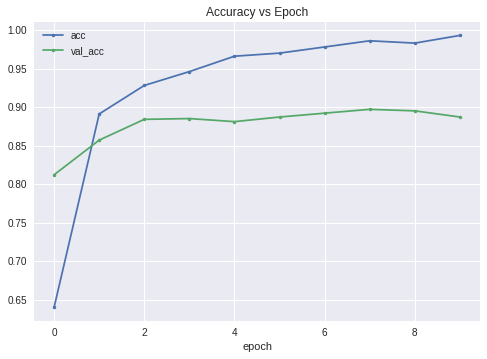

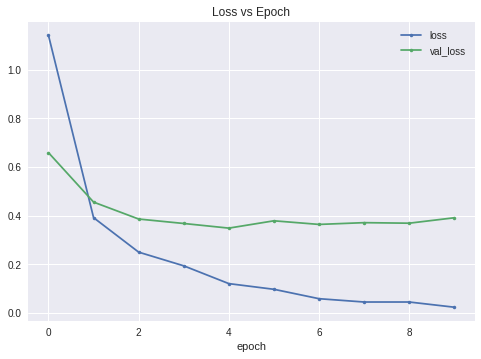

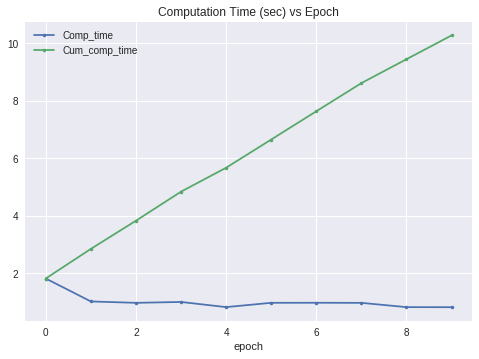

### Model id:  14


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
140,0,relu,64,1.850075,1.850075,0.0,sparse_categorical_crossentropy,Adam_lr0.0001,MNIST_1000samples,14,CNN,0.569,1.925275,0.714,1.575687
141,1,relu,64,0.806837,2.656912,0.0,sparse_categorical_crossentropy,Adam_lr0.0001,MNIST_1000samples,14,CNN,0.799,1.121968,0.764,1.017722
142,2,relu,64,0.848249,3.505161,0.0,sparse_categorical_crossentropy,Adam_lr0.0001,MNIST_1000samples,14,CNN,0.849,0.676559,0.797,0.751451
143,3,relu,64,0.874555,4.379715,0.0,sparse_categorical_crossentropy,Adam_lr0.0001,MNIST_1000samples,14,CNN,0.882,0.482756,0.815,0.621820
144,4,relu,64,0.793408,5.173124,0.0,sparse_categorical_crossentropy,Adam_lr0.0001,MNIST_1000samples,14,CNN,0.900,0.388342,0.827,0.565478
145,5,relu,64,0.796560,5.969683,0.0,sparse_categorical_crossentropy,Adam_lr0.0001,MNIST_1000samples,14,CNN,0.907,0.335110,0.843,0.504192
146,6,relu,64,0.795196,6.764879,0.0,sparse_categorical_crossentropy,Adam_lr0.0001,MNIST_1000samples,14,CNN,0.934,0.284348,0.850,0.468904
147,7,relu,64,0.803139,7.568018,0.0,sparse_categorical_crossentropy,Adam_lr0.0001,MNIST_1000samples,14,CNN,0.940,0.247966,0.853,0.449854
148,8,relu,64,0.797667,8.365684,0.0,sparse_categorical_crossentropy,Adam_lr0.0001,MNIST_1000samples,14,CNN,0.946,0.222162,0.855,0.443773
149,9,relu,64,0.798299,9.163984,0.0,sparse_categorical_crossentropy,Adam_lr0.0001,MNIST_1000samples,14,CNN,0.957,0.200142,0.857,0.438323


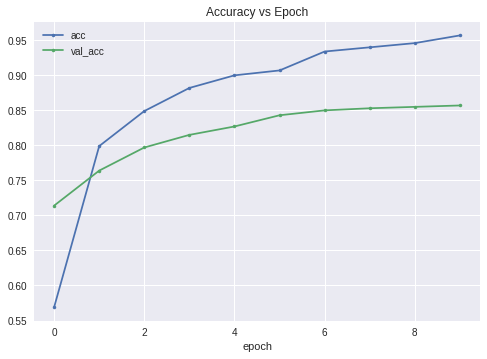

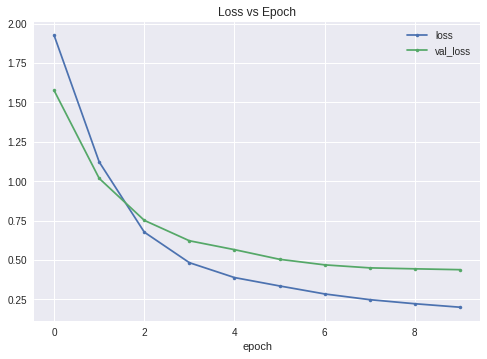

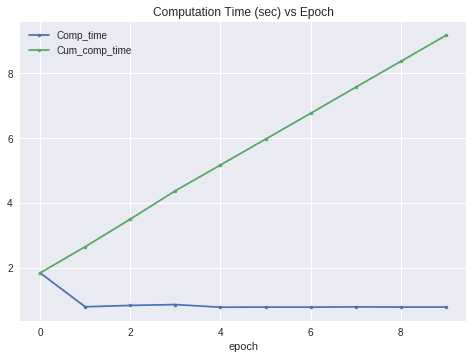

### Model id:  15


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
150,0,relu,64,1.852765,1.852765,0.0,sparse_categorical_crossentropy,Adam_lr0.01,MNIST_1000samples,15,CNN,0.684,1.537265,0.750,0.948618
151,1,relu,64,0.855145,2.707910,0.0,sparse_categorical_crossentropy,Adam_lr0.01,MNIST_1000samples,15,CNN,0.926,0.267788,0.882,0.381094
152,2,relu,64,0.807804,3.515713,0.0,sparse_categorical_crossentropy,Adam_lr0.01,MNIST_1000samples,15,CNN,0.985,0.082197,0.901,0.347458
153,3,relu,64,0.798071,4.313784,0.0,sparse_categorical_crossentropy,Adam_lr0.01,MNIST_1000samples,15,CNN,0.999,0.011592,0.902,0.368690
154,4,relu,64,0.642114,4.955898,0.0,sparse_categorical_crossentropy,Adam_lr0.01,MNIST_1000samples,15,CNN,1.000,0.002427,0.897,0.400132
155,5,relu,64,0.640931,5.596829,0.0,sparse_categorical_crossentropy,Adam_lr0.01,MNIST_1000samples,15,CNN,1.000,0.000825,0.898,0.410862
156,6,relu,64,0.643044,6.239873,0.0,sparse_categorical_crossentropy,Adam_lr0.01,MNIST_1000samples,15,CNN,1.000,0.000464,0.901,0.415353
157,7,relu,64,0.792335,7.032208,0.0,sparse_categorical_crossentropy,Adam_lr0.01,MNIST_1000samples,15,CNN,1.000,0.000323,0.903,0.418572
158,8,relu,64,0.648262,7.680471,0.0,sparse_categorical_crossentropy,Adam_lr0.01,MNIST_1000samples,15,CNN,1.000,0.000260,0.903,0.422083
159,9,relu,64,0.656359,8.336829,0.0,sparse_categorical_crossentropy,Adam_lr0.01,MNIST_1000samples,15,CNN,1.000,0.000220,0.903,0.425770


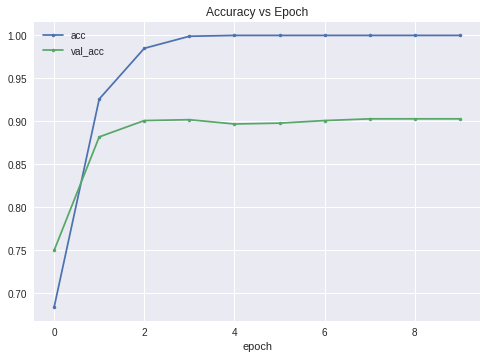

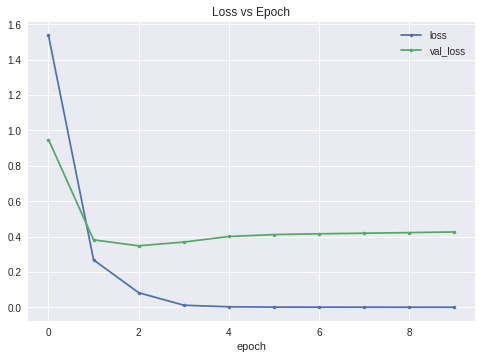

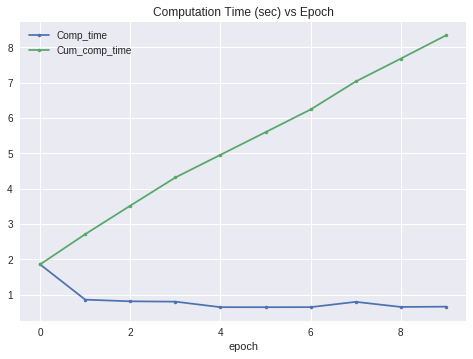

### Model id:  16


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
160,0,relu,64,1.987695,1.987695,0.0,sparse_categorical_crossentropy,Adam_lr0.1,MNIST_1000samples,16,CNN,0.096,13.831658,0.085,14.748059
161,1,relu,64,0.640666,2.628360,0.0,sparse_categorical_crossentropy,Adam_lr0.1,MNIST_1000samples,16,CNN,0.097,14.554642,0.085,14.748059
162,2,relu,64,0.647641,3.276001,0.0,sparse_categorical_crossentropy,Adam_lr0.1,MNIST_1000samples,16,CNN,0.097,14.554642,0.085,14.748059
163,3,relu,64,0.639058,3.915060,0.0,sparse_categorical_crossentropy,Adam_lr0.1,MNIST_1000samples,16,CNN,0.097,14.554642,0.085,14.748059
164,4,relu,64,0.645268,4.560328,0.0,sparse_categorical_crossentropy,Adam_lr0.1,MNIST_1000samples,16,CNN,0.097,14.554642,0.085,14.748059
165,5,relu,64,0.644545,5.204873,0.0,sparse_categorical_crossentropy,Adam_lr0.1,MNIST_1000samples,16,CNN,0.097,14.554642,0.085,14.748059
166,6,relu,64,0.646883,5.851756,0.0,sparse_categorical_crossentropy,Adam_lr0.1,MNIST_1000samples,16,CNN,0.097,14.554642,0.085,14.748059
167,7,relu,64,0.642989,6.494745,0.0,sparse_categorical_crossentropy,Adam_lr0.1,MNIST_1000samples,16,CNN,0.097,14.554642,0.085,14.748059
168,8,relu,64,0.641599,7.136343,0.0,sparse_categorical_crossentropy,Adam_lr0.1,MNIST_1000samples,16,CNN,0.097,14.554642,0.085,14.748059
169,9,relu,64,0.643804,7.780147,0.0,sparse_categorical_crossentropy,Adam_lr0.1,MNIST_1000samples,16,CNN,0.097,14.554642,0.085,14.748059


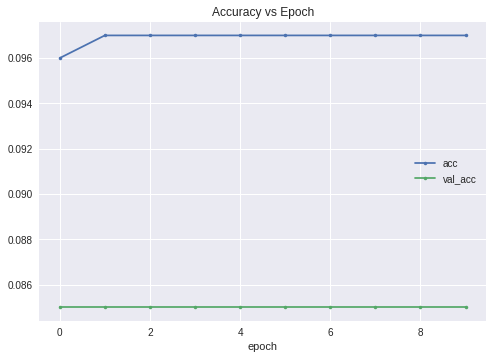

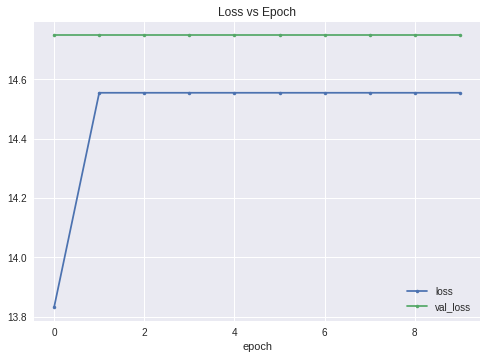

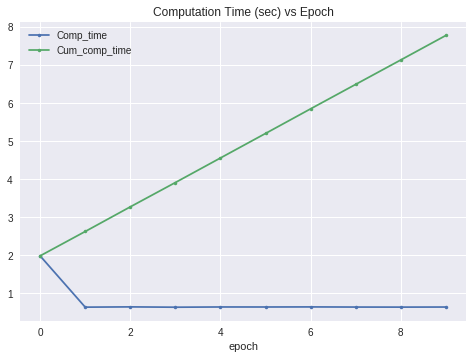

### Model id:  17


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
170,0,relu,64,1.763748,1.763748,0.0,sparse_categorical_crossentropy,SGD,MNIST_1000samples,17,CNN,0.468,2.238415,0.636,2.175292
171,1,relu,64,0.708024,2.471772,0.0,sparse_categorical_crossentropy,SGD,MNIST_1000samples,17,CNN,0.695,2.065722,0.664,2.002579
172,2,relu,64,0.701077,3.172849,0.0,sparse_categorical_crossentropy,SGD,MNIST_1000samples,17,CNN,0.740,1.816027,0.686,1.747942
173,3,relu,64,0.712797,3.885646,0.0,sparse_categorical_crossentropy,SGD,MNIST_1000samples,17,CNN,0.765,1.490648,0.692,1.450885
174,4,relu,64,0.713677,4.599323,0.0,sparse_categorical_crossentropy,SGD,MNIST_1000samples,17,CNN,0.794,1.170870,0.722,1.195939
175,5,relu,64,0.709382,5.308705,0.0,sparse_categorical_crossentropy,SGD,MNIST_1000samples,17,CNN,0.817,0.932001,0.755,1.014859
176,6,relu,64,0.715001,6.023706,0.0,sparse_categorical_crossentropy,SGD,MNIST_1000samples,17,CNN,0.832,0.775174,0.765,0.898382
177,7,relu,64,0.732270,6.755975,0.0,sparse_categorical_crossentropy,SGD,MNIST_1000samples,17,CNN,0.850,0.671719,0.772,0.808824
178,8,relu,64,0.722326,7.478301,0.0,sparse_categorical_crossentropy,SGD,MNIST_1000samples,17,CNN,0.857,0.601580,0.786,0.754151
179,9,relu,64,0.711087,8.189388,0.0,sparse_categorical_crossentropy,SGD,MNIST_1000samples,17,CNN,0.864,0.549167,0.795,0.706271


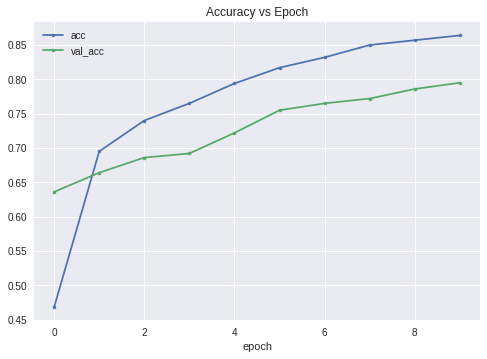

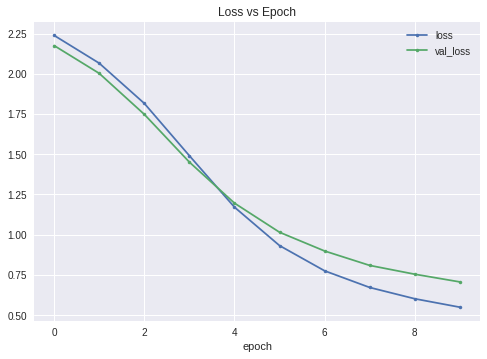

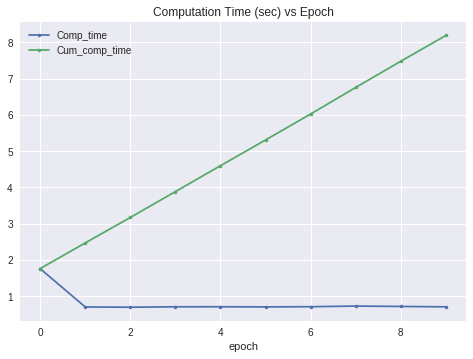

### Model id:  18


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
180,0,relu,64,1.769008,1.769008,0.0,sparse_categorical_crossentropy,SGD_momentum_0.5,MNIST_1000samples,18,CNN,0.496,2.174356,0.632,2.018420
181,1,relu,64,0.702748,2.471756,0.0,sparse_categorical_crossentropy,SGD_momentum_0.5,MNIST_1000samples,18,CNN,0.727,1.703254,0.685,1.487611
182,2,relu,64,0.726897,3.198653,0.0,sparse_categorical_crossentropy,SGD_momentum_0.5,MNIST_1000samples,18,CNN,0.804,1.096282,0.749,1.020215
183,3,relu,64,0.721502,3.920154,0.0,sparse_categorical_crossentropy,SGD_momentum_0.5,MNIST_1000samples,18,CNN,0.831,0.742846,0.772,0.820876
184,4,relu,64,0.721400,4.641554,0.0,sparse_categorical_crossentropy,SGD_momentum_0.5,MNIST_1000samples,18,CNN,0.854,0.588937,0.795,0.699911
185,5,relu,64,0.718256,5.359810,0.0,sparse_categorical_crossentropy,SGD_momentum_0.5,MNIST_1000samples,18,CNN,0.865,0.508665,0.804,0.639016
186,6,relu,64,0.717918,6.077728,0.0,sparse_categorical_crossentropy,SGD_momentum_0.5,MNIST_1000samples,18,CNN,0.873,0.451046,0.816,0.602604
187,7,relu,64,0.713002,6.790730,0.0,sparse_categorical_crossentropy,SGD_momentum_0.5,MNIST_1000samples,18,CNN,0.891,0.414218,0.823,0.571773
188,8,relu,64,0.713075,7.503805,0.0,sparse_categorical_crossentropy,SGD_momentum_0.5,MNIST_1000samples,18,CNN,0.893,0.385380,0.825,0.545584
189,9,relu,64,0.724753,8.228558,0.0,sparse_categorical_crossentropy,SGD_momentum_0.5,MNIST_1000samples,18,CNN,0.894,0.365269,0.830,0.545987


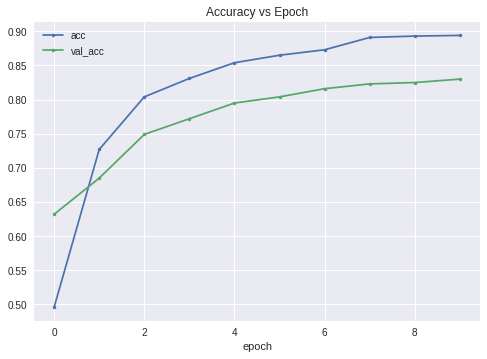

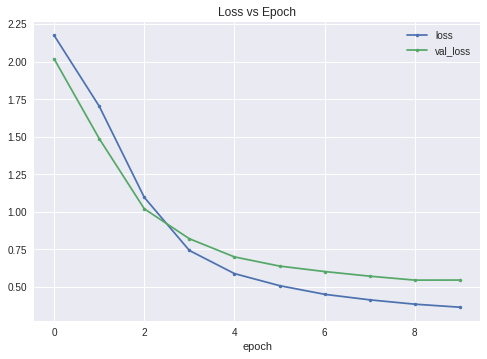

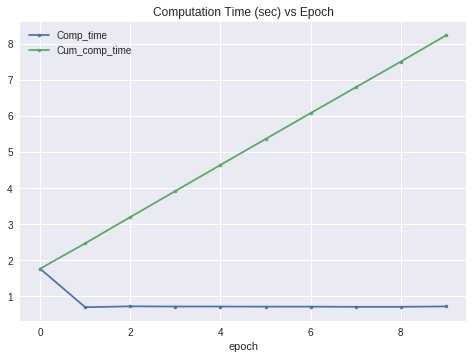

### Model id:  19


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
190,0,relu,64,1.857121,1.857121,0.0,sparse_categorical_crossentropy,SGD_momentum_0.9,MNIST_1000samples,19,CNN,0.460,1.991005,0.676,1.348193
191,1,relu,64,0.707052,2.564172,0.0,sparse_categorical_crossentropy,SGD_momentum_0.9,MNIST_1000samples,19,CNN,0.805,0.722640,0.780,0.663700
192,2,relu,64,0.717657,3.281829,0.0,sparse_categorical_crossentropy,SGD_momentum_0.9,MNIST_1000samples,19,CNN,0.873,0.426559,0.808,0.584018
193,3,relu,64,0.714535,3.996364,0.0,sparse_categorical_crossentropy,SGD_momentum_0.9,MNIST_1000samples,19,CNN,0.889,0.355116,0.836,0.511149
194,4,relu,64,0.715247,4.711611,0.0,sparse_categorical_crossentropy,SGD_momentum_0.9,MNIST_1000samples,19,CNN,0.913,0.301359,0.843,0.488449
195,5,relu,64,0.610859,5.322470,0.0,sparse_categorical_crossentropy,SGD_momentum_0.9,MNIST_1000samples,19,CNN,0.927,0.257233,0.835,0.556459
196,6,relu,64,0.608164,5.930633,0.0,sparse_categorical_crossentropy,SGD_momentum_0.9,MNIST_1000samples,19,CNN,0.926,0.232586,0.841,0.521000
197,7,relu,64,0.710078,6.640712,0.0,sparse_categorical_crossentropy,SGD_momentum_0.9,MNIST_1000samples,19,CNN,0.948,0.201350,0.846,0.513261
198,8,relu,64,0.607523,7.248234,0.0,sparse_categorical_crossentropy,SGD_momentum_0.9,MNIST_1000samples,19,CNN,0.942,0.209248,0.822,0.548064
199,9,relu,64,0.602795,7.851029,0.0,sparse_categorical_crossentropy,SGD_momentum_0.9,MNIST_1000samples,19,CNN,0.943,0.177830,0.842,0.520802


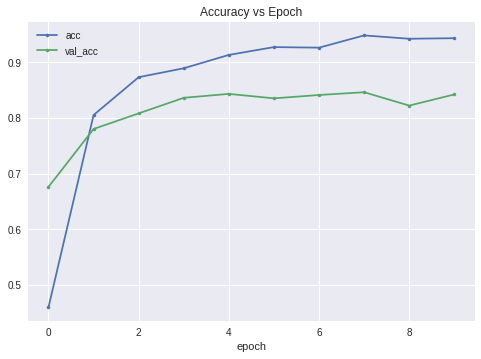

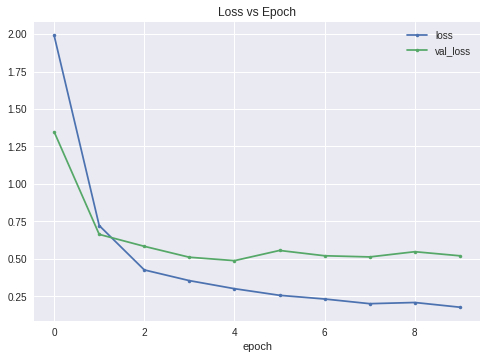

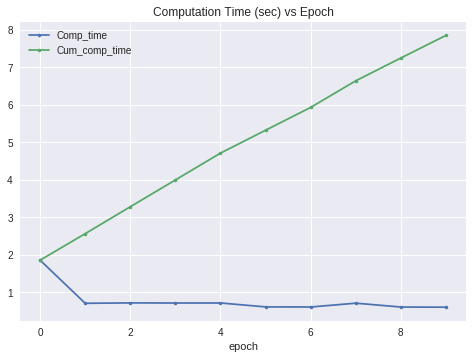

### Model id:  20


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
200,0,relu,64,1.926070,1.926070,0.0,sparse_categorical_crossentropy,SGD_momentum_0.99,MNIST_1000samples,20,CNN,0.568,1.896615,0.683,1.036392
201,1,relu,64,0.707112,2.633182,0.0,sparse_categorical_crossentropy,SGD_momentum_0.99,MNIST_1000samples,20,CNN,0.816,0.671296,0.790,1.067698
202,2,relu,64,0.713249,3.346431,0.0,sparse_categorical_crossentropy,SGD_momentum_0.99,MNIST_1000samples,20,CNN,0.873,0.744423,0.829,1.124684
203,3,relu,64,0.609721,3.956151,0.0,sparse_categorical_crossentropy,SGD_momentum_0.99,MNIST_1000samples,20,CNN,0.896,0.687390,0.829,1.400402
204,4,relu,64,0.604186,4.560337,0.0,sparse_categorical_crossentropy,SGD_momentum_0.99,MNIST_1000samples,20,CNN,0.909,0.530791,0.792,1.464805
205,5,relu,64,0.610512,5.170849,0.0,sparse_categorical_crossentropy,SGD_momentum_0.99,MNIST_1000samples,20,CNN,0.903,0.452593,0.776,1.058206
206,6,relu,64,0.605942,5.776791,0.0,sparse_categorical_crossentropy,SGD_momentum_0.99,MNIST_1000samples,20,CNN,0.931,0.322413,0.800,0.633283
207,7,relu,64,0.600781,6.377572,0.0,sparse_categorical_crossentropy,SGD_momentum_0.99,MNIST_1000samples,20,CNN,0.959,0.229743,0.823,0.606837
208,8,relu,64,0.718129,7.095701,0.0,sparse_categorical_crossentropy,SGD_momentum_0.99,MNIST_1000samples,20,CNN,0.972,0.170317,0.830,0.779560
209,9,relu,64,0.727263,7.822964,0.0,sparse_categorical_crossentropy,SGD_momentum_0.99,MNIST_1000samples,20,CNN,0.976,0.142960,0.837,0.888411


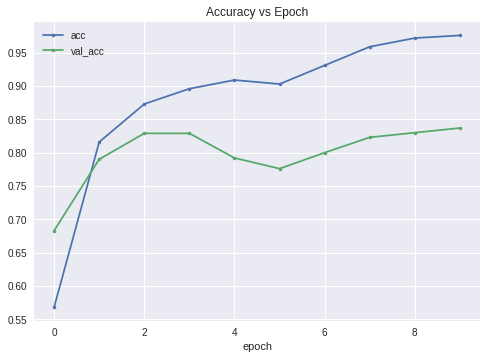

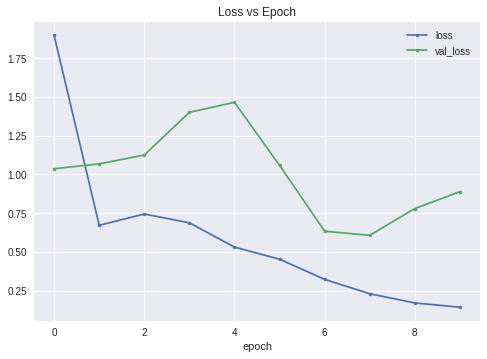

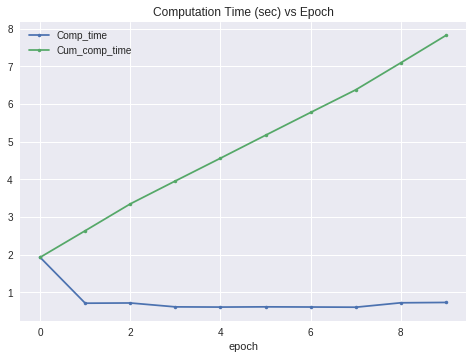

### Model id:  21


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
210,0,relu,64,1.937103,1.937103,0.0,sparse_categorical_crossentropy,RMSprop,MNIST_1000samples,21,CNN,0.665,1.113667,0.795,0.587634
211,1,relu,64,0.736670,2.673774,0.0,sparse_categorical_crossentropy,RMSprop,MNIST_1000samples,21,CNN,0.901,0.323422,0.869,0.402231
212,2,relu,64,0.736887,3.410661,0.0,sparse_categorical_crossentropy,RMSprop,MNIST_1000samples,21,CNN,0.954,0.177540,0.880,0.370421
213,3,relu,64,0.632890,4.043551,0.0,sparse_categorical_crossentropy,RMSprop,MNIST_1000samples,21,CNN,0.977,0.083547,0.843,0.482762
214,4,relu,64,0.761711,4.805262,0.0,sparse_categorical_crossentropy,RMSprop,MNIST_1000samples,21,CNN,0.995,0.039091,0.884,0.388505
215,5,relu,64,0.742259,5.547521,0.0,sparse_categorical_crossentropy,RMSprop,MNIST_1000samples,21,CNN,0.999,0.013772,0.885,0.422864
216,6,relu,64,0.633436,6.180957,0.0,sparse_categorical_crossentropy,RMSprop,MNIST_1000samples,21,CNN,1.000,0.006802,0.867,0.529859
217,7,relu,64,0.734081,6.915038,0.0,sparse_categorical_crossentropy,RMSprop,MNIST_1000samples,21,CNN,0.993,0.021063,0.903,0.380433
218,8,relu,64,0.624361,7.539400,0.0,sparse_categorical_crossentropy,RMSprop,MNIST_1000samples,21,CNN,1.000,0.001596,0.898,0.406381
219,9,relu,64,0.631932,8.171332,0.0,sparse_categorical_crossentropy,RMSprop,MNIST_1000samples,21,CNN,1.000,0.000684,0.895,0.455436


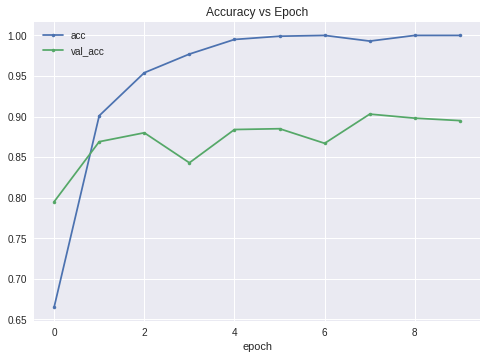

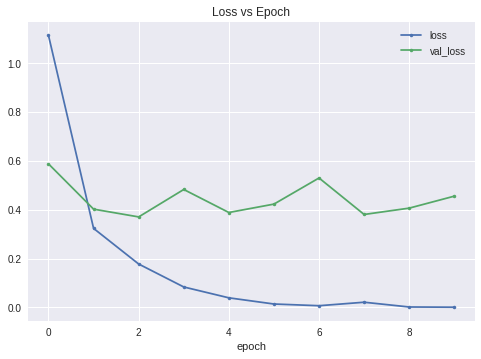

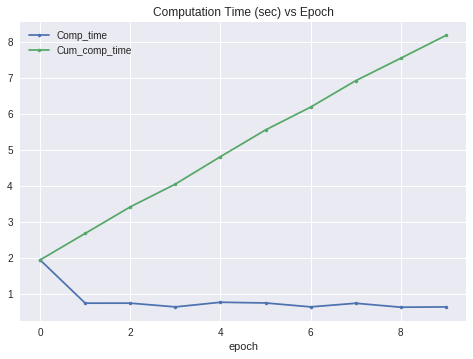

### Model id:  22


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
220,0,relu,64,1.939203,1.939203,0.0,sparse_categorical_crossentropy,Adagrad,MNIST_1000samples,22,CNN,0.645,1.609789,0.764,0.696281
221,1,relu,64,0.727692,2.666895,0.0,sparse_categorical_crossentropy,Adagrad,MNIST_1000samples,22,CNN,0.928,0.250812,0.871,0.412656
222,2,relu,64,0.736184,3.403079,0.0,sparse_categorical_crossentropy,Adagrad,MNIST_1000samples,22,CNN,0.976,0.123449,0.884,0.379817
223,3,relu,64,0.720786,4.123865,0.0,sparse_categorical_crossentropy,Adagrad,MNIST_1000samples,22,CNN,0.991,0.066506,0.886,0.339051
224,4,relu,64,0.735203,4.859068,0.0,sparse_categorical_crossentropy,Adagrad,MNIST_1000samples,22,CNN,0.997,0.036262,0.887,0.343483
225,5,relu,64,0.736438,5.595506,0.0,sparse_categorical_crossentropy,Adagrad,MNIST_1000samples,22,CNN,1.000,0.020691,0.890,0.347096
226,6,relu,64,0.622176,6.217682,0.0,sparse_categorical_crossentropy,Adagrad,MNIST_1000samples,22,CNN,1.000,0.013780,0.889,0.352889
227,7,relu,64,0.735989,6.953671,0.0,sparse_categorical_crossentropy,Adagrad,MNIST_1000samples,22,CNN,1.000,0.009962,0.892,0.358581
228,8,relu,64,0.626033,7.579704,0.0,sparse_categorical_crossentropy,Adagrad,MNIST_1000samples,22,CNN,1.000,0.007730,0.892,0.357419
229,9,relu,64,0.619104,8.198808,0.0,sparse_categorical_crossentropy,Adagrad,MNIST_1000samples,22,CNN,1.000,0.006309,0.890,0.358607


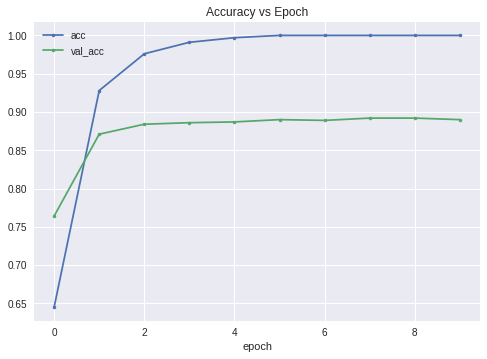

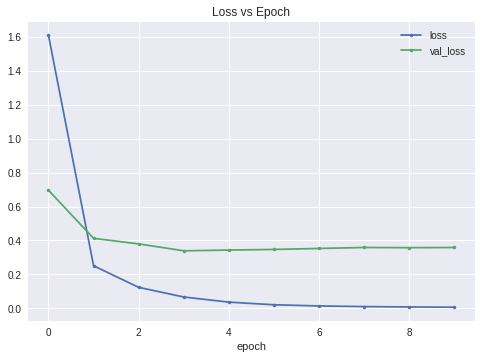

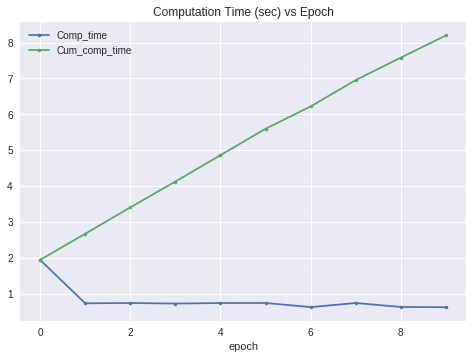

### Model id:  23


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
230,0,relu,64,2.171760,2.171760,0.0,sparse_categorical_crossentropy,Adadelta,MNIST_1000samples,23,CNN,0.623,1.168330,0.659,1.204026
231,1,relu,64,0.833416,3.005176,0.0,sparse_categorical_crossentropy,Adadelta,MNIST_1000samples,23,CNN,0.838,0.531120,0.778,0.636626
232,2,relu,64,0.808419,3.813595,0.0,sparse_categorical_crossentropy,Adadelta,MNIST_1000samples,23,CNN,0.889,0.320755,0.842,0.507775
233,3,relu,64,0.829721,4.643316,0.0,sparse_categorical_crossentropy,Adadelta,MNIST_1000samples,23,CNN,0.946,0.210142,0.854,0.417731
234,4,relu,64,0.663254,5.306570,0.0,sparse_categorical_crossentropy,Adadelta,MNIST_1000samples,23,CNN,0.959,0.144614,0.839,0.496012
235,5,relu,64,0.811397,6.117967,0.0,sparse_categorical_crossentropy,Adadelta,MNIST_1000samples,23,CNN,0.969,0.109486,0.863,0.439672
236,6,relu,64,0.662874,6.780840,0.0,sparse_categorical_crossentropy,Adadelta,MNIST_1000samples,23,CNN,0.986,0.063712,0.845,0.484490
237,7,relu,64,0.827585,7.608425,0.0,sparse_categorical_crossentropy,Adadelta,MNIST_1000samples,23,CNN,0.993,0.042115,0.864,0.430642
238,8,relu,64,0.804022,8.412448,0.0,sparse_categorical_crossentropy,Adadelta,MNIST_1000samples,23,CNN,1.000,0.022605,0.868,0.477484
239,9,relu,64,0.808205,9.220653,0.0,sparse_categorical_crossentropy,Adadelta,MNIST_1000samples,23,CNN,1.000,0.014245,0.878,0.469861


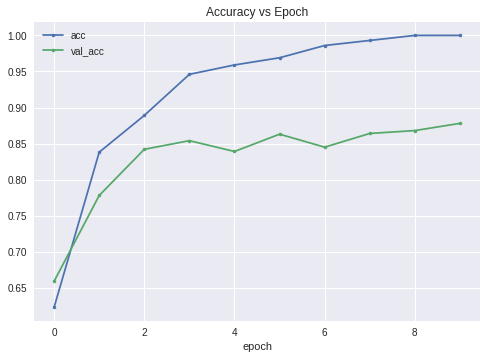

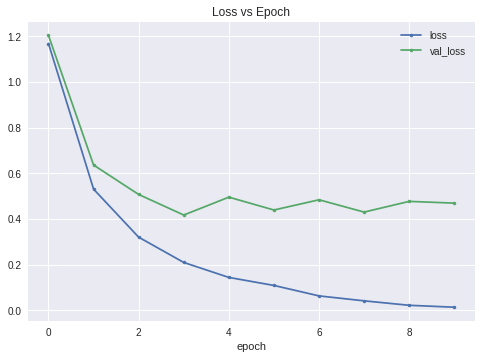

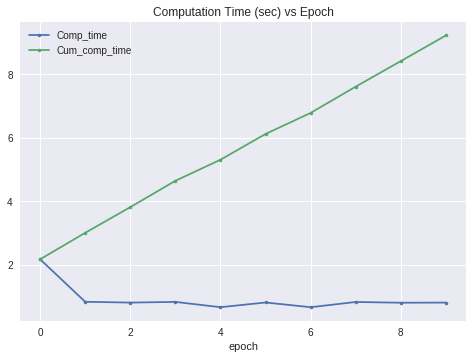

In [0]:
## Plot the results
# pd.options.display.max_rows = 8
lfp.plot_log(show_table=True)


References:


https://keras.io/callbacks/

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

https://keras.io/getting-started/sequential-model-guide/